In [26]:
import mbuild as mb
import warnings 
warnings.filterwarnings('ignore')
import foyer
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import hoomd
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
butane = mb.load("CCCC", smiles=True)
#butane.visualize()

In [3]:
box = mb.fill_box(compound = butane,
                 n_compounds=1, 
                 density=0.01)

In [4]:
#box.visualize() #is this supposed to show the box around it?

In [5]:
gaff = foyer.Forcefield(forcefield_files = "../repos/GAFF-foyer/gafffoyer/xml/gaff.xml")

In [6]:
box_typed = gaff.apply(box)

In [7]:
#stripping the H atoms away so its only a 4 particle system
box_typed.strip([a.atomic_number == 1 for a in box_typed])

In [8]:
#Showing the difference btwn box_typed and box
#type(box_typed) 
#type(box)
#parmed structure contains all the info like bond distance and stickiness 
#in a file that can be used to run a hoomd simulation

In [9]:
#showing the parameters needed for the simulation from the force field
#for atom in box_typed.atoms:
#    print(atom.sigma)
#    print(atom.epsilon)

In [54]:
snap, forcefield, refs = create_hoomd_forcefield(box_typed, r_cut = 2.5, auto_scale=True)

Processing LJ and QQ
No charged groups found, ignoring electrostatics
Processing 1-4 interactions, adjusting neighborlist exclusions
Processing harmonic bonds
Processing harmonic angles
Processing periodic torsions


In [55]:
#setting cpu and simulation 
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu,seed=0)
sim.create_state_from_snapshot(snap)

In [56]:
#setting the integrator
kt = 4
free_particle = hoomd.filter.Tags(tags=[0,1])  #letting hoomd know which particles to update the positions of
integrator = hoomd.md.Integrator(dt=0.0001)
nvt = hoomd.md.methods.NVT(kT=kt,filter=free_particle, tau=0.1)
integrator.forces = forcefield
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.state.thermalize_particle_momenta(filter=free_particle, kT=kt)
# Set up GSD writer
gsd_writer = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(int(2e2)),
    filename="traj_dihedral.gsd",  #name the output file
    mode="wb"
)
sim.operations.writers.append(gsd_writer)

In [36]:
print(forcefield[-1].params['c3-c3-c3-c3'])

_HOOMDDict{'k': 3.2906764168190126, 'd': 1.0, 'n': 3, 'phi0': 0.0}


In [57]:
sim.run(10e6)

In [ ]:
traj = gsd.hoomd.open("traj_dihedral.gsd")

In [ ]:
len(traj)

In [ ]:
snapshot = traj[10]

In [ ]:
snapshot.particles.position

In [18]:
from cmeutils.structure import dihedral_distribution

In [58]:
dist = dihedral_distribution(
    'traj_dihedral.gsd',
    A_name = "c3", 
    B_name = "c3", 
    C_name = "c3", 
    D_name = "c3", 
    histogram = True, 
    degrees = False
)

Text(0.5, 1.0, 'dihedral distribution')

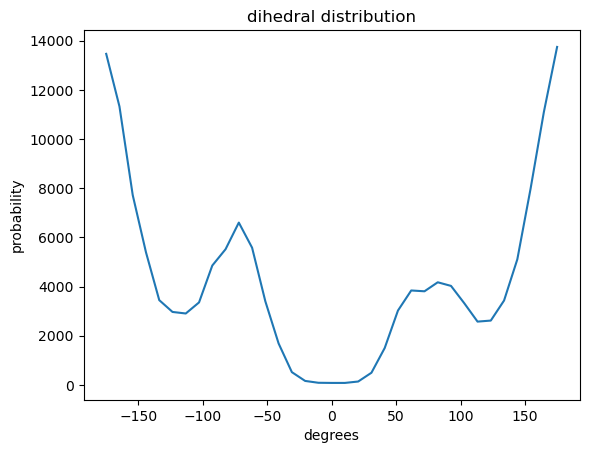

In [59]:
plt.plot(np.rad2deg(dist[:,0]), dist[:,1])
plt.xlabel('degrees')
plt.ylabel('probability')
plt.title('dihedral distribution')

In [60]:
def harmonic_dihedral(phi,k,d,n,phi0):
    energy = 0.5 * k*(1 + d*np.cos(n * phi - phi0))
    return energy

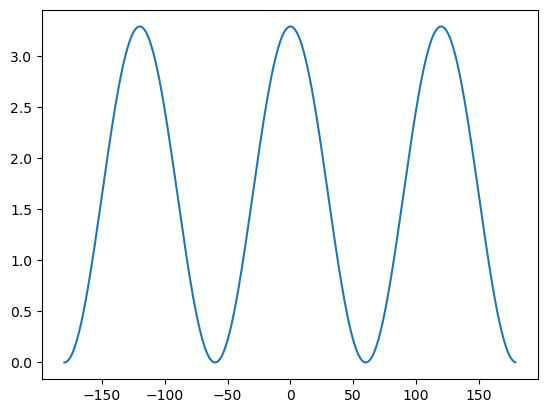

In [61]:
phi_range = np.arange(-np.pi,np.pi,np.pi/200)
dihedral_energy = harmonic_dihedral(phi_range,3.2907, 1.0, 3, 0)
plt.plot(np.rad2deg(phi_range), dihedral_energy)

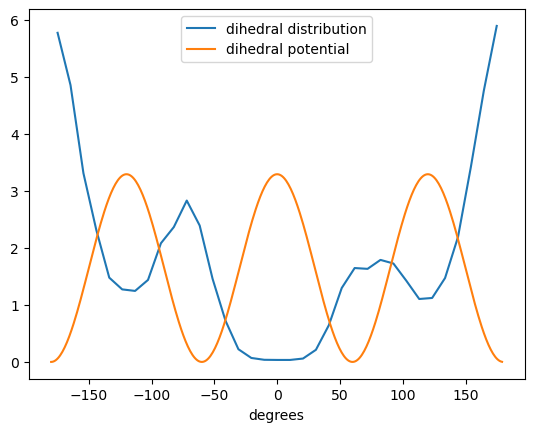

In [62]:
plt.plot(np.rad2deg(dist[:,0]), dist[:,1]/2333, label = 'dihedral distribution')
plt.plot(np.rad2deg(phi_range), dihedral_energy, label = 'dihedral potential')
plt.xlabel('degrees')
plt.legend()